In [1]:
library(stringr)
library(RColorBrewer)
library(parallel)

In [2]:
setwd("/nfs/lab/projects/pbmc_snATAC/analysis_v2")

In [3]:
barcode_list = read.table('peaks/pbmc1-15_clusterLabels.txt',   sep="\t",header=T)

In [4]:
bc = str_split_fixed(barcode_list$X, "\\_",2)

barcode_list$barcode = paste0("CB:Z:", bc[,2], "-1")
barcode_list = barcode_list[order(as.numeric(substring(barcode_list$sample,5))),]

In [6]:
barcode_list$broad_populations_2 = gsub("cd8_","" ,barcode_list$broad_populations)
barcode_list$broad_populations_2 = gsub("cd4_","" ,barcode_list$broad_populations_2)


In [10]:
table(barcode_list$fine_populations, barcode_list$broad_populations_2)

             
                  b   mkc  mono    nk   pDC plasma     t
  act_cd4_t       0     0     0     0     0      0 15494
  adaptive_NK     0     0     0   883     0      0     0
  cDC             0     0   954     0     0      0     0
  cMono           0     0 22208     0     0      0     0
  cyto_cd8_t      0     0     0     0     0      0  8892
  cyto_nk         0     0     0  8584     0      0     0
  iMono           0     0  3330     0     0      0     0
  mem_b        2158     0     0     0     0      0     0
  mem_cd8_t       0     0     0     0     0      0  2494
  mkc             0  1120     0     0     0      0     0
  naive_b      5166     0     0     0     0      0     0
  naive_cd4_t     0     0     0     0     0      0 11995
  naive_cd8_t     0     0     0     0     0      0  5589
  ncMono          0     0  4484     0     0      0     0
  pDC             0     0     0     0   380      0     0
  plasma          0     0     0     0     0    167     0
  tReg           

In [7]:
table(barcode_list$broad_populations_2, barcode_list$broad_populations)

        
             b cd4_t cd8_t   mkc  mono    nk   pDC plasma
  b       7324     0     0     0     0     0     0      0
  mkc        0     0     0  1120     0     0     0      0
  mono       0     0     0     0 30976     0     0      0
  nk         0     0     0     0     0  9467     0      0
  pDC        0     0     0     0     0     0   380      0
  plasma     0     0     0     0     0     0     0    167
  t          0 29593 16975     0     0     0     0      0

In [10]:
write.table(barcode_list,'peaks/pbmc1-15_clusterLabels.txt',   sep="\t", quote=F)

### Fine Populations

In [6]:
tb = table(barcode_list$fine_populations, as.numeric(substring(barcode_list$sample,5)))

In [7]:
apply(tb,1,median)

act_cd4_t adaptive_NK         cDC       cMono  cyto_cd8_t     cyto_nk 
       1096          54          59        1603         499         522 
      iMono       mem_b   mem_cd8_t         mkc     naive_b naive_cd4_t 
         80         162         151          62         347         623 
naive_cd8_t      ncMono         pDC      plasma        tReg 
        296         286          28          10         146

In [8]:
rownames(tb)[apply(tb,1,median)>50]

[1] "act_cd4_t"   "adaptive_NK" "cDC"         "cMono"       "cyto_cd8_t" 
 [6] "cyto_nk"     "iMono"       "mem_b"       "mem_cd8_t"   "mkc"        
[11] "naive_b"     "naive_cd4_t" "naive_cd8_t" "ncMono"      "tReg"

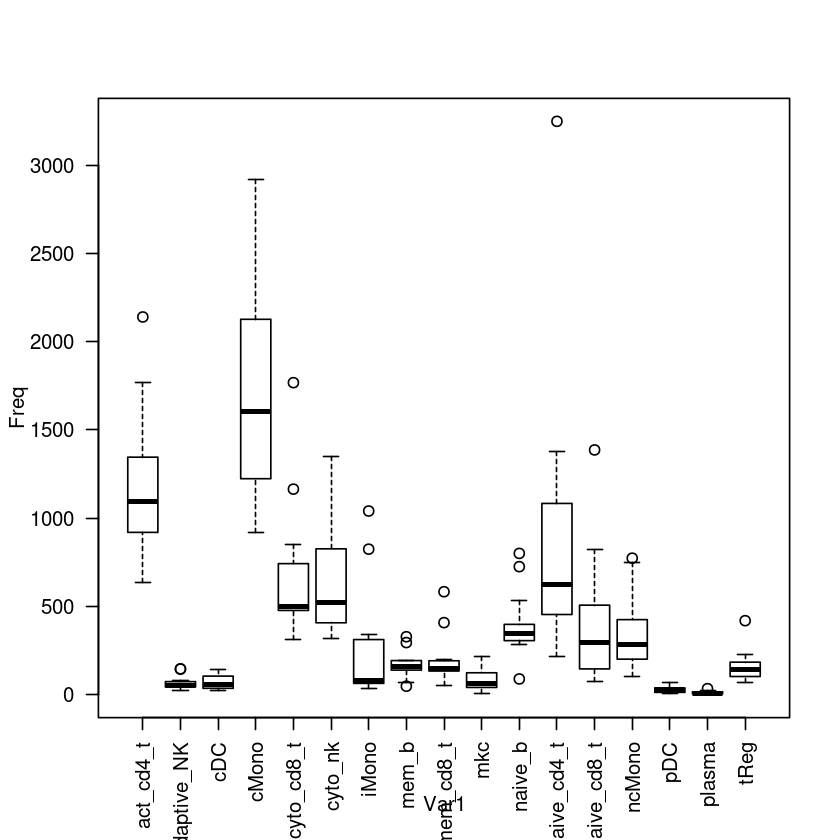

In [9]:
boxplot( Freq~Var1,as.data.frame((tb)), las=2)

In [10]:
length(unique(barcode_list$fine_populations))
length(unique(barcode_list$broad_populations))

[1] 17

[1] 8

In [11]:
make_cluster_bam = function(s, celltypes, sampdir, outdir) {
    
     sample      = paste0("pbmc",s)
     samp_outdir = paste0( outdir,  '/PBMC', s, '/fine')
     system(paste('mkdir -p', samp_outdir))
     setwd(samp_outdir)
     bam         = paste0(sampdir, "/PBMC", s, '/final/PBMC', s, '.merged.rmdup.final.bam' )
     system(paste("samtools view -H", bam ,"> SAM_header"))
   
    for (cell in celltypes) {
        
        barcodes = barcode_list$barcode[barcode_list$sample==sample & barcode_list$fine_populations==cell]
        writeLines(barcodes, cell)
        system(paste('samtools view', bam , '| LC_ALL=C grep -F -f', cell , '> filtered_SAM_body'))
        system("cat SAM_header filtered_SAM_body > filtered.sam")
        system(paste0("samtools view -b filtered.sam > ", sample, "_",cell, ".bam"))
        system('rm filtered.sam filtered_SAM_body')
        system(paste0("samtools index ", sample, "_",cell, ".bam"))
}

     
}

In [ ]:
ids = c(1:6, 8:10, 12:15)
sampdir = "/nfs/lab/projects/pbmc_snATAC/analysis_v2/wasp_peaks/singlecell/"
outdir  = "/nfs/lab/projects/pbmc_snATAC/analysis_v2/cell_type_bam/"
celltypes = rownames(tb)[apply(tb,1,median)>50]
mclapply(ids, function(x) make_cluster_bam(s=x, celltypes=celltypes, sampdir=sampdir ,outdir=outdir) , mc.cores = 32)  

### Broad populations

In [8]:
tb = table(barcode_list$broad_populations_2, as.numeric(substring(barcode_list$sample,5)))

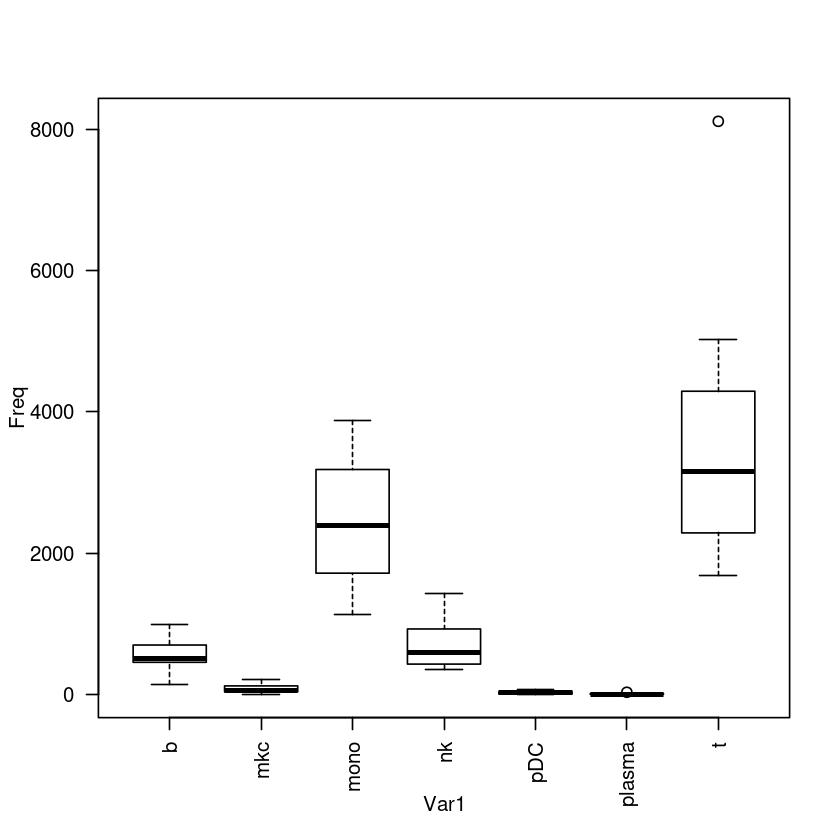

In [9]:
boxplot( Freq~Var1,as.data.frame((tb)), las=2)

In [10]:
make_cluster_bam = function(s, celltypes, sampdir, outdir) {
    
     sample      = paste0("pbmc",s)
     samp_outdir = paste0( outdir,  '/PBMC', s, '/broad')
     system(paste('mkdir -p', samp_outdir))
     setwd(samp_outdir)
     bam         = paste0(sampdir, "/PBMC", s, '/final/PBMC', s, '.merged.rmdup.final.bam' )
     system(paste("samtools view -H", bam ,"> SAM_header"))
   
    for (cell in celltypes) {
        
        #barcodes = barcode_list$barcode[barcode_list$sample==sample & barcode_list$broad_populations==cell]
        barcodes = barcode_list$barcode[barcode_list$sample==sample & barcode_list$broad_populations_2==cell]
        writeLines(barcodes, cell)
        system(paste('samtools view', bam , '| LC_ALL=C grep -F -f', cell , '> filtered_SAM_body'))
        system("cat SAM_header filtered_SAM_body > filtered.sam")
        system(paste0("samtools view -b filtered.sam > ", sample, "_",cell, ".bam"))
        system('rm filtered.sam filtered_SAM_body')
        system(paste0("samtools index ", sample, "_",cell, ".bam"))
}

     
}

In [ ]:
ids = c(1:6, 8:10, 12:15)
sampdir = "/nfs/lab/projects/pbmc_snATAC/analysis_v2/wasp_peaks/singlecell/"
outdir  = "/nfs/lab/projects/pbmc_snATAC/analysis_v2/cell_type_bam/"
celltypes = rownames(tb)[apply(tb,1,median)>100]
mclapply(ids, function(x) make_cluster_bam(s=x, celltypes=celltypes, sampdir=sampdir ,outdir=outdir) , mc.cores = 32)  

In [ ]:
ids = c(1:6, 8:10, 12:15)
sampdir = "/nfs/lab/projects/pbmc_snATAC/analysis_v2/wasp_peaks/singlecell/"
outdir  = "/nfs/lab/projects/pbmc_snATAC/analysis_v2/cell_type_bam/"
celltypes = "t"
mclapply(ids, function(x) make_cluster_bam(s=x, celltypes=celltypes, sampdir=sampdir ,outdir=outdir) , mc.cores = 32)  